# 1. Sobre paquetes

si hace falta, correr:

```sh
!python -m spacy download es_core_news_sm
```

después todas las otras librerías no debería ser muy diferente, 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import spacy
from colorama import Fore, Style

# Load the dataset
df = pd.read_csv('../data/cleaned_with_lemmatized_reviews.csv')

# Selecting the 'review' column and removing missing values
reviews = df['review'].dropna()

# Load the Spanish language model for Spacy
nlp = spacy.load('es_core_news_sm')


ModuleNotFoundError: No module named 'textblob_es'

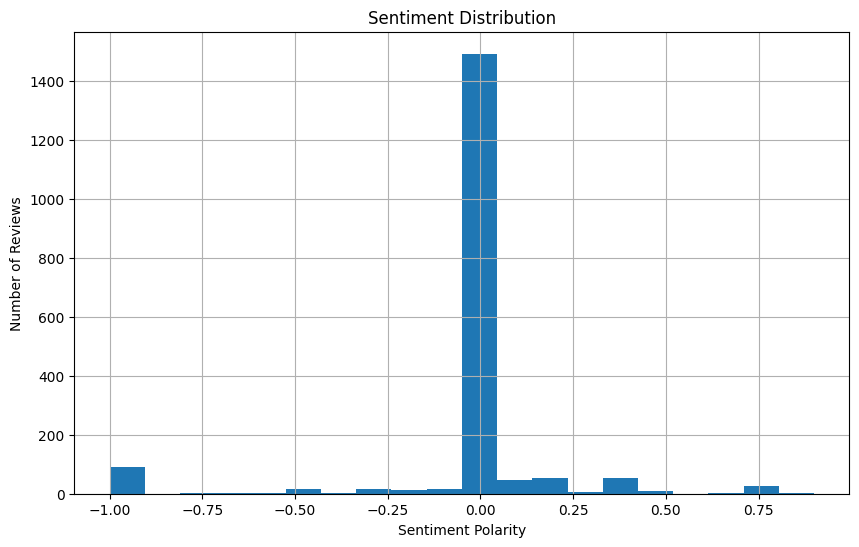

In [47]:
# 1. Sentiment Analysis
def get_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

# Applying the sentiment function
df['sentiment'] = reviews.apply(get_sentiment)

# Plotting sentiment distribution
plt.figure(figsize=(10, 6))
df['sentiment'].hist(bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.show()

In [48]:

# 2. Topic Modeling with LDA
airline_stopwords = ['empresa','llegar', 'volar', 'aerolínea', 'vuelo', 'viajar', 'compañía', 'flybondi', 'aeropuerto', 'viaje', 'avión', 'pasar', 'querer', 'volver']

stop_words = list(spacy.lang.es.stop_words.STOP_WORDS) + airline_stopwords
# max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words".
# min_df is used for removing terms that appear too infrequently.
vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words=stop_words)
# columns: words, rows: documents
dtm = vectorizer.fit_transform(reviews)

# Fitting the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {Fore.BLUE}{topic_idx}{Style.RESET_ALL}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)



Topic 0:
excelente servicio precio personal horario experiencia atención salir ida vuelta
Topic 1:
asiento cobrar equipaje pagar check in low servicio valija cost
Topic 2:
hora cambiar dinero servicio horario cliente tiempo cancelar cambio comprar
Topic 3:
cancelar salir reprogramar pasaje cambiar desastre hora hs horario vuelta
Topic 4:
hora aire pagar cambiar correo esperar hotel argentino perder tomar


In [49]:

# 3. Word Frequency and N-grams Analysis
vectorizer_ngrams = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words)
# each row is a review and each column is a n-gram
# the matrix contains the count of how often each n-gram appears in each review
X_ngrams = vectorizer_ngrams.fit_transform(reviews)

# Summing up the occurrences of n-grams from the table
sum_ngrams = X_ngrams.sum(axis=0) # sum of n-grams
ngrams_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer_ngrams.vocabulary_.items()] # <ngran, freq>
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True) # sort by frequency

# Display top N bigrams/trigrams
N = 100
print(f"Top {N} Bigrams/Trigrams:")
for phrase, freq in ngrams_freq[:N]:
    print(f"{phrase}: {Fore.BLUE}{freq}{Style.RESET_ALL}")


Top 100 Bigrams/Trigrams:
ida vuelta: 120
check in: 114
salir caro: 108
low cost: 104
cambiar horario: 102
correo electrónico: 77
barato salir: 77
comprar pasaje: 76
devolver dinero: 57
atención cliente: 55
pésimo servicio: 53
bs as: 53
cambio horario: 46
salir horario: 45
servicio cliente: 36
terminar salir: 30
equipaje mano: 30
atención personal: 30
fly bondi: 29
cancelar hora: 29
hora esperar: 29
retrasar hora: 27
salir hora: 27
sacar pasaje: 26
malo experiencia: 26
atender teléfono: 26
excelente servicio: 26
valer pena: 25
noche hotel: 25
previo aviso: 24
perder tiempo: 24
12 hora: 24
servicio bordo: 22
comprar boleto: 22
cumplir horario: 22
cancelar reprogramar: 21
sitio web: 20
puerto iguazú: 20
devolver plata: 20
salir palomar: 20
arruinar vacaciones: 19
faltar respeto: 19
jugar tiempo: 19
12 hs: 19
defensa consumidor: 19
hora hora: 18
enviar correo: 18
hora salir: 17
jorge newbery: 17
hora retraso: 17
retraso hora: 17
reprogramar hora: 17
aerolinea argentino: 17
personal amable

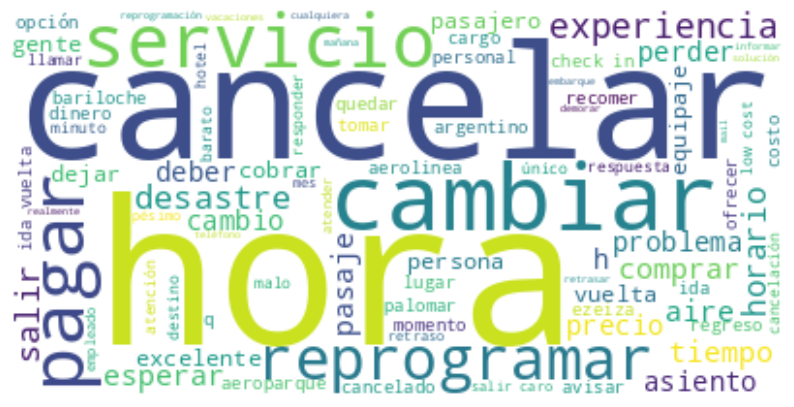

In [50]:

# 4. Word Cloud Visualization
wordcloud = WordCloud(background_color='white', stopwords=set(stop_words)).generate(' '.join(reviews))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [56]:
# 5. Term Frequency-Inverse Document Frequency (TF-IDF)
# TF = (Number of times term t appears in a document) / (Total number of terms in the document)
# IDF = log_e(Total number of documents / Number of documents with term t in it)
# TF-IDF = TF * IDF
# TF meassures how often a term appears in a document
# IDF meassures how unique a term is across all documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10, stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(reviews) # each row is a review and each column is a word
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out() # list of words corresponding to the columns

# Display top words with highest TF-IDF scores
def top_tfidf_features(row, features, top_n=10):
    topn_ids = row.argsort()[-top_n:]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    return top_feats

df_filtered = df[df['review'].notna()]  # Ensure we drop rows with missing reviews
df_filtered = df_filtered.iloc[:tfidf.shape[0]]  # Align the DataFrame with the number of rows in tfidf

# Ensure indices are aligned by using 'enumerate' to index both DataFrame and TF-IDF matrix
df_filtered['top_tfidf_features'] = [
    top_tfidf_features(tfidf[i].toarray()[0], tfidf_feature_names, 10) for i in range(tfidf.shape[0])
]

# Display the reviews with their corresponding top TF-IDF features
df_filtered[['review', 'top_tfidf_features']].head()
# THE HIGHER THE TF-IDF SCORE, THE MORE IMPORTANT THE WORD IS IN THE DOCUMENT

,review,top_tfidf_features
0,malisimo malisimola peor vuando perder día hot...,"[(hotel, 0.18629177311408662), (bondi, 0.24756..."
1,uno peor voladohar volado ciento aerolíneasest...,"[(piso, 0.2266051991176259), (volado, 0.233262..."
2,terrible servicioel vuelo retrasar primero vez...,"[(aterrizar, 0.1872923488566574), (perdido, 0...."
3,basco aerolínea bajo costocompré 6 boleto trav...,"[(boleto, 0.1481095602811177), (mostrador, 0.1..."
4,no reembolsar vuelo canceladosno reembolsar vu...,"[(dinero, 0.0), (dirección, 0.0), (directament..."


In [58]:

# 6. Aspect-Based Sentiment Analysis (ABSA)
aspects = ['vuelo', 'atención', 'precio', 'servicio', 'comodidad']

def aspect_sentiment_analysis(review, aspects):
    sentiments = {}
    doc = nlp(review)
    for token in doc:
        for aspect in aspects:
            if aspect in token.text:
                sentiments[aspect] = get_sentiment(review)
    return sentiments

df['aspect_sentiment'] = reviews.apply(lambda x: aspect_sentiment_analysis(x, aspects))

# Display aspect-based sentiment analysis results
df[['review', 'aspect_sentiment']].head()


,review,aspect_sentiment
0,malisimo malisimola peor vuando perder día hot...,{}
1,uno peor voladohar volado ciento aerolíneasest...,{'vuelo': 0.0}
2,terrible servicioel vuelo retrasar primero vez...,"{'servicio': -1.0, 'vuelo': -1.0}"
3,basco aerolínea bajo costocompré 6 boleto trav...,{'servicio': 0.0}
4,no reembolsar vuelo canceladosno reembolsar vu...,{'vuelo': 0.0}


In [53]:

# 7. Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['entities'] = reviews.apply(extract_entities)

# Display NER results
df[['review', 'entities']].head()

,review,entities
0,malisimo malisimola peor vuando perder día hot...,[]
1,uno peor voladohar volado ciento aerolíneasest...,[]
2,terrible servicioel vuelo retrasar primero vez...,"[(terrible servicioel vuelo, MISC)]"
3,basco aerolínea bajo costocompré 6 boleto trav...,"[(basco, PER)]"
4,no reembolsar vuelo canceladosno reembolsar vu...,[]
